In [1]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


%matplotlib inline

In [2]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

In [10]:
def ROC_sk(filename, amp, site, ax):
    '''
    Plots ROC-curve to an axis and returns AUC value
    
    filename: string, file used
    amp: float, simulus strength
    site: int, index of chosen denrite
    ax: matplotlib axis to plot to
    
    returns: AUC value
    '''
    f = h5py.File(filename+".hdf5", "r")
    
    data = f['data']
    meta = f['meta']
    #read out data
    
    stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]
    #get all stimuli (except zero)
    
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)
    #make sure valid stimulus is chosen

    baseline = np.mean(data[:,:,:58], axis=2).reshape(data.shape[0], data.shape[1], 1)
    #compute baseline

    mn_dnd_chng = np.mean(data[:,:,58:116]-baseline, axis=2)
    #mean dendritic change

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    #get masks of trials where chosen stimulus is present and zero
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    #combine these masks
    
    y_score = mn_dnd_chng[trials_mask, site]
    #apply mask to data
    
    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    #get trial outcomes
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    AUC = auc(fpr, tpr, reorder=False)
    #do DOC analysis (scikit learn)
    
    #plotting to passed axis
    n_steps = thresholds.shape[0]
    
    ax.plot(fpr, tpr)
    ax.fill_between(fpr, np.zeros(n_steps), tpr, facecolor="#D47F00", alpha=0.8)
        
    ax.plot(np.linspace(0,1,n_steps), np.linspace(0,1,n_steps), color='k', linestyle='--')
    ax.set_aspect('equal')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    return AUC

In [13]:
def get_DIs(filename, amp, permute=False):
    '''
    Computes DIs for all recordings sites of file 'filename' and amplitude 'amp'.
    
    filename: string, name of file used
    amp: stimulus strength
    permute: bool, if true, labels are shuffeled
    
    returns: list of DI values after motion mask is applied
    '''
    f = h5py.File(filename+".hdf5", "r")

    data = f['data']
    meta = f['meta']
    #get data
    
    g = h5py.File(filename[:-6]+"roi.hdf5", "r")
    motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
    #compute motion_mask that invalidates bad dendrites
    
    stims = np.unique(h5py.File(filename+".hdf5", "r")['meta'][:,1])[1:]
    #get all stimuli (except zero)
    
    assert(amp in list(stims)), "this stimAmp was not used in chosen experiment. Cose one from {}.".format(stims)
    #make sure chosen amp is valid

    baseline = np.mean(data[:,motion_mask,:58], axis=2).reshape(data.shape[0], np.sum(motion_mask), 1)
    #compute baseline

    mn_dnd_chng = np.mean(data[:,motion_mask,58:116]-baseline, axis=2)
    #mean dendritic activity

    present_mask = meta[:,1]==amp
    absent_mask = meta[:,1]==0
    #get masks for chosen and zero trials
    
    trials_mask = np.logical_or(present_mask, absent_mask)
    #combine masks
    
    amp_mask = meta[:,1][trials_mask]==amp
    y_true = (amp_mask-0.5)*2
    if permute==True:
        y_true = np.random.permutation(y_true)
    #compute labels, if permute is true permute these after
    
    DIs = []
    for site in range(np.sum(motion_mask)):
        y_score = mn_dnd_chng[trials_mask, site]
    
        DIs.append((roc_auc_score(y_true, y_score)-0.5)*2)
    #compute DI score for each dendrite
    
    return DIs

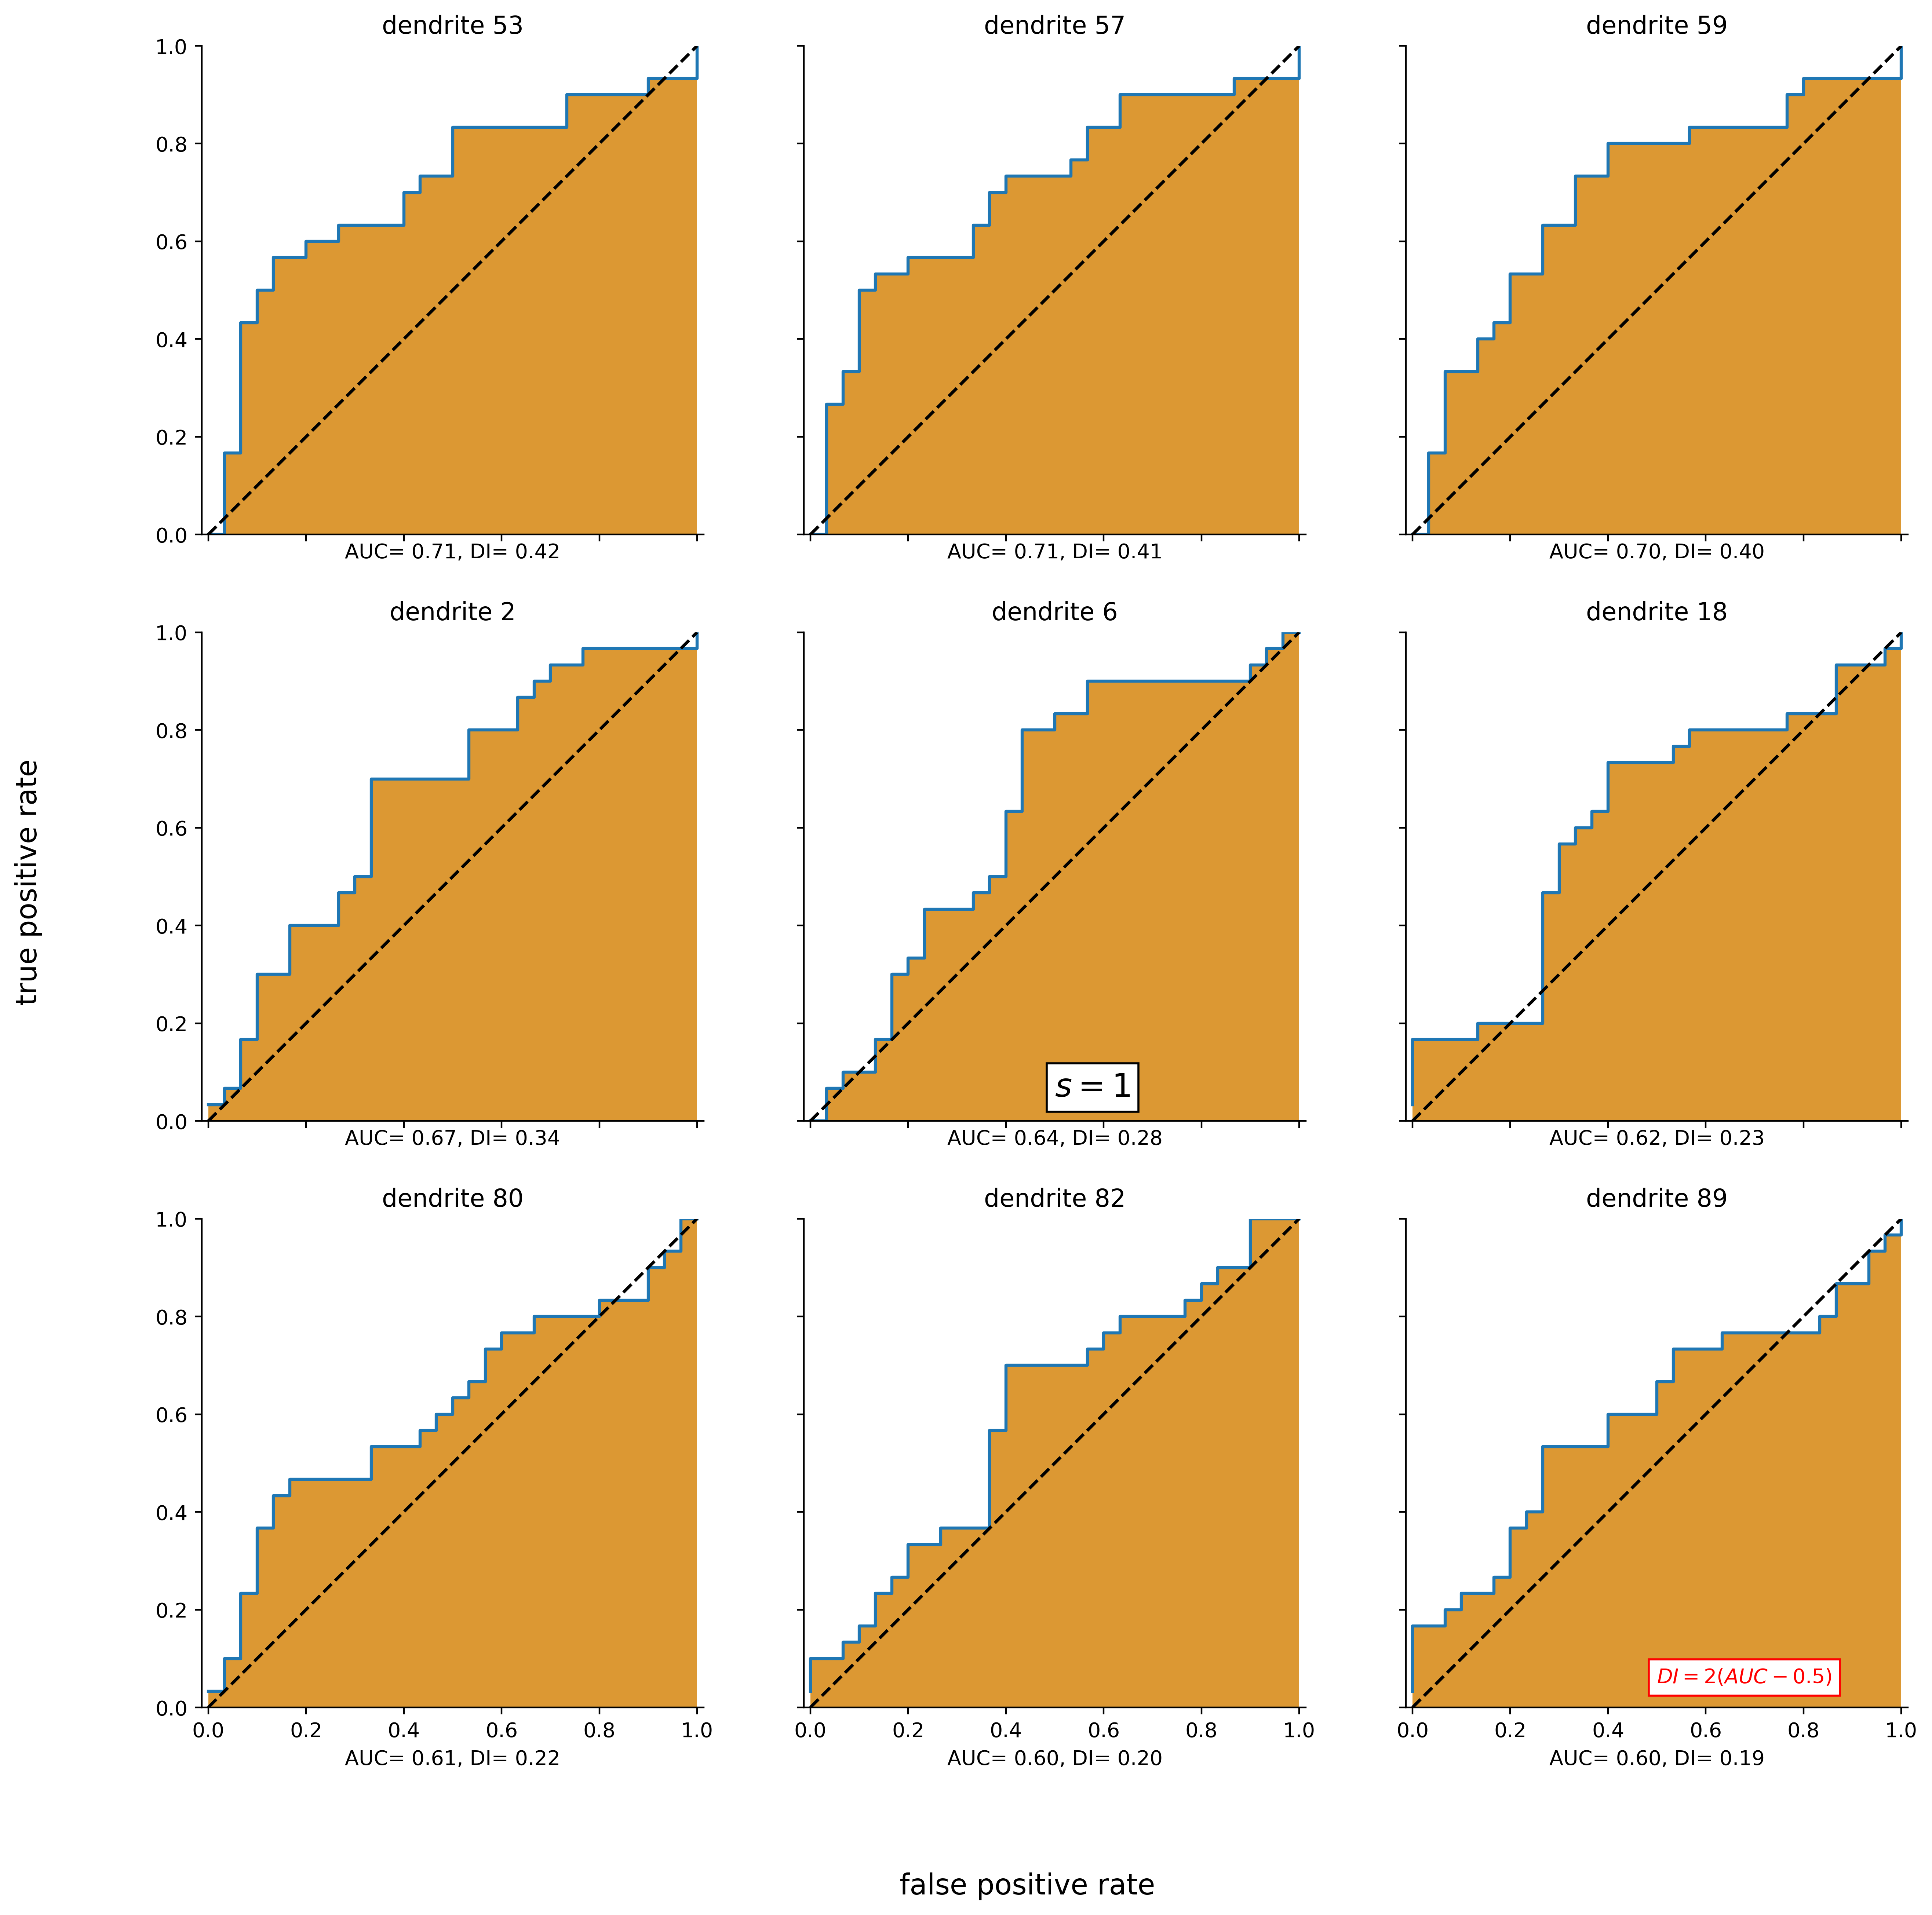

In [12]:
filename = filelist[2]
stim_amp = 1
#chose file and stimulus

g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
#compute motion mask

sort = 'max'
#if max, chose biggest DIs, if min, smallest

DIs = np.array(get_DIs(filename, stim_amp))
#compute DIs

if sort == 'max':
    inds = np.argsort(DIs)[::-1][:9]
if sort == 'min':
    inds = np.argsort(DIs)[:9]
if sort == 'rand':
    inds = np.random.choice(n_dendrites, 9, replace=False)

n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15,15), dpi=400)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for k, i in enumerate(inds):
    c=0
    for j in range(len(motion_mask)):
        if c == i:
                break
        if motion_mask[j] == True:
            c += 1
    AUC = ROC_sk(filename, stim_amp, j, axes[k])
    axes[k].set_title('dendrite {}'.format(j))
    axes[k].set_xlabel('AUC={0: .2f}, DI={1: .2f}'.format(AUC, (AUC-0.5)*2))
#somewhat convoluted, but we compute AUCs and plot to axis. We make sure that we have the 
#right indiced of the dendrites (because we applied the motion mask in get_DIs)

axes[k].text(0.5, 0.05, '$DI = 2(AUC-0.5)$', color='red', 
        bbox=dict(facecolor='white', edgecolor='red'))

axes[4].text(0.5, 0.05, '$s = 1$', color='black', 
        bbox=dict(facecolor='white', edgecolor='black'), fontsize=16)

if sort == 'max':
    fig.text(0.5, 0.04, 'false positive rate', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'true positive rate', va='center', rotation='vertical', fontsize=14)
if sort == 'min':
    fig.text(0.5, 0.04, 'true positive rate', ha='center', fontsize=14)
    fig.text(0.04, 0.5, 'false positive rate', va='center', rotation='vertical', fontsize=14)
    
fig.savefig('roc_{}.png'.format(sort))

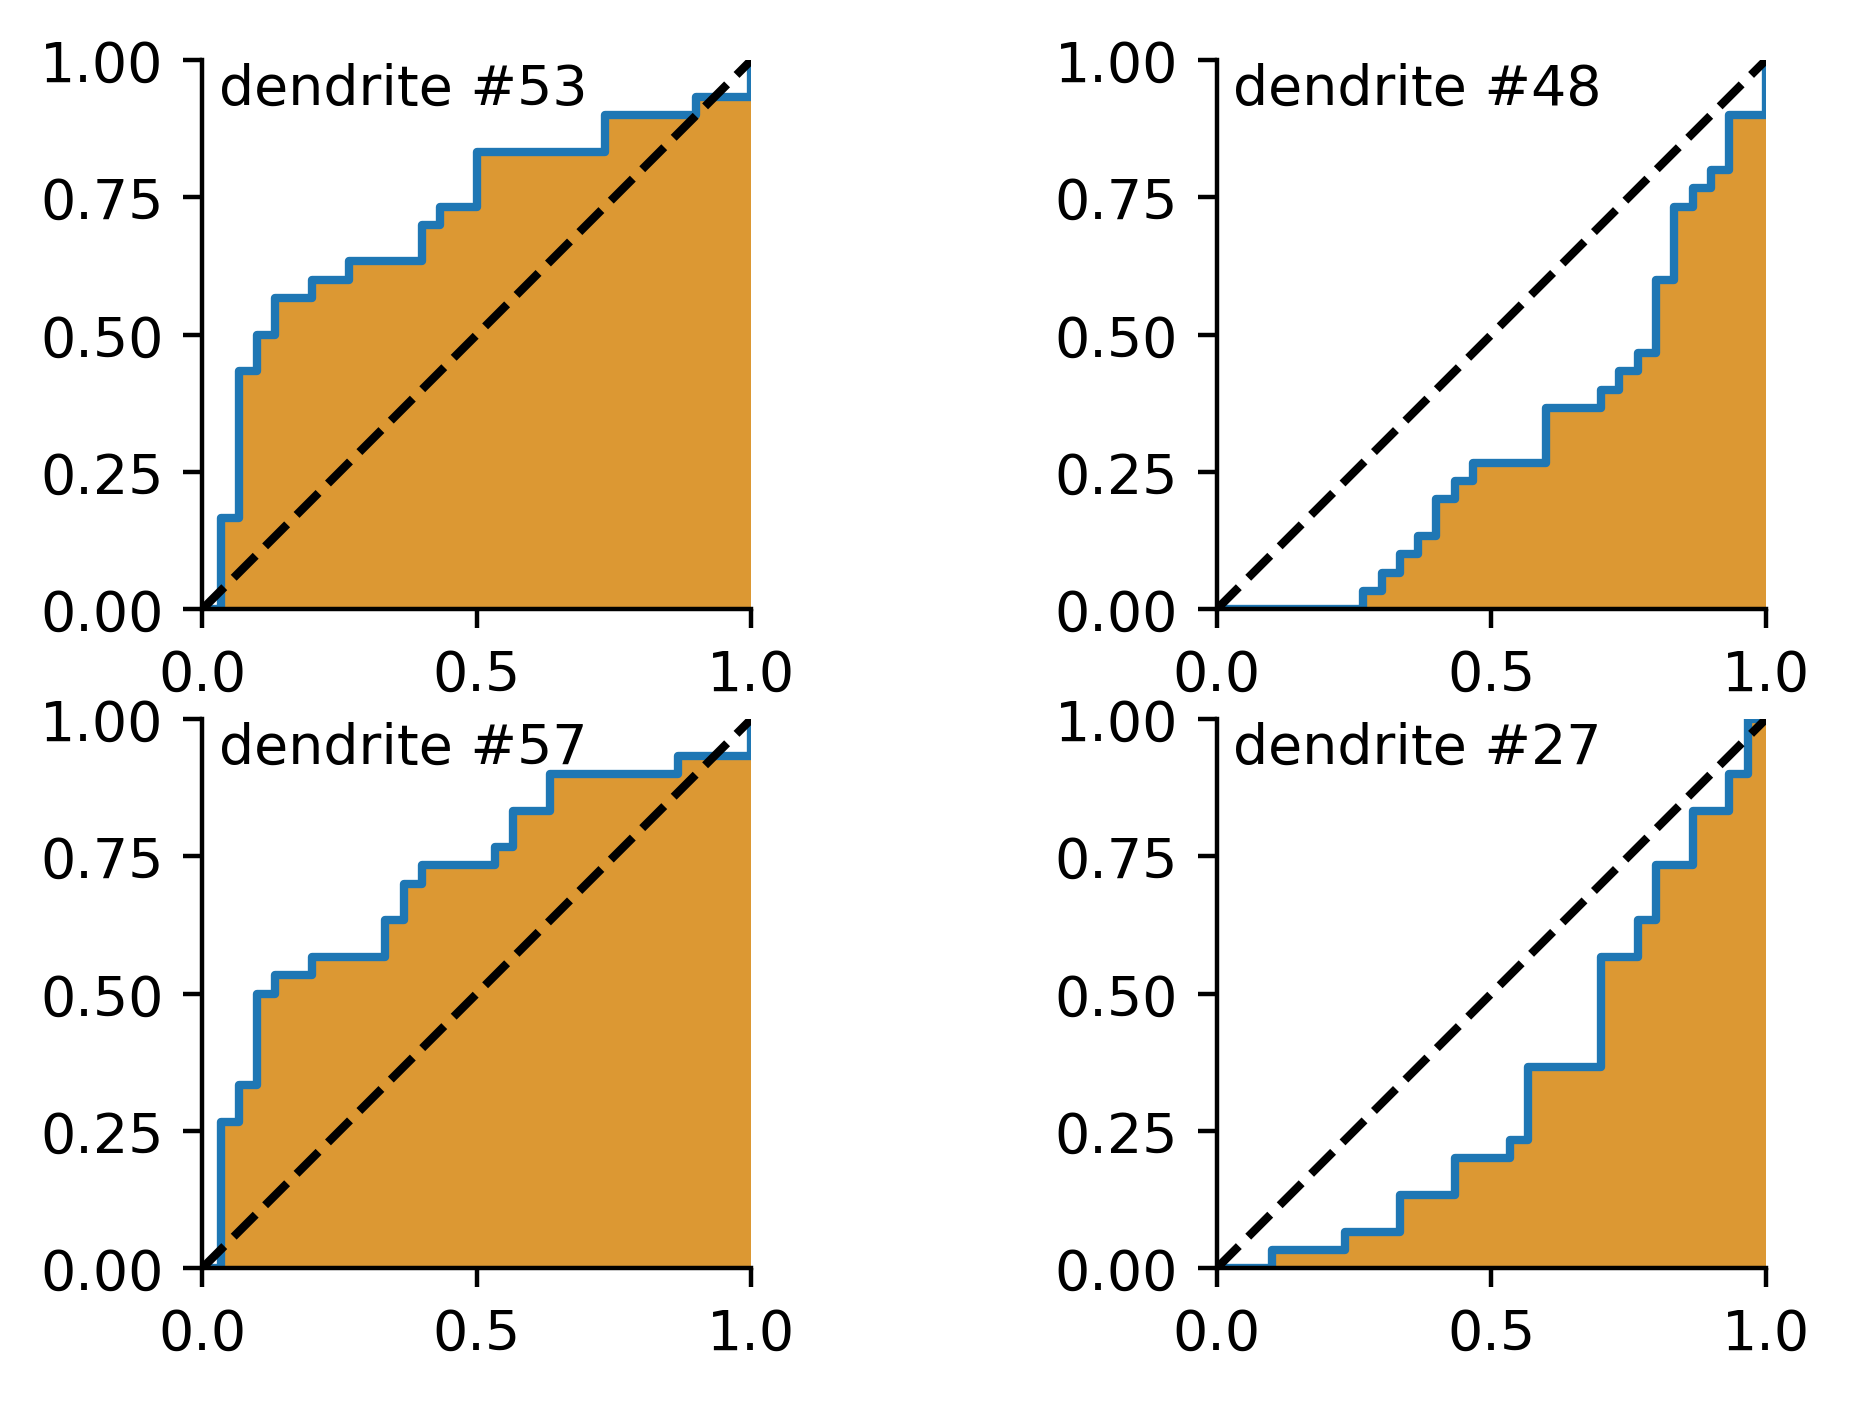

In [14]:
filename = filelist[2]
stim_amp = 1
#chose file and stimulus strength

g = h5py.File(filename[:-6]+"roi.hdf5", "r")
motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
#get motion mask

DIs = np.array(get_DIs(filename, stim_amp))

inds_max = np.argsort(DIs)[::-1][:2]
    
inds_min = np.argsort(DIs)[:2]
#get ordered indices of DIs from smallest to largest and from largest to smallest

n_dendrites = h5py.File(filename+".hdf5", "r")['data'].shape[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=400)
axes = [ax1, ax2, ax3, ax4]

for l, k in enumerate([0,1,2,3]):
    if k in [0, 2]:
        c=0
        for j in range(len(motion_mask)):
            if c == inds_max[l//2]:
                    break
            if motion_mask[j] == True:
                c += 1
        AUC = ROC_sk(filename, stim_amp, j, axes[k])
        axes[k].text(0.03, 0.92, s='dendrite #{}'.format(j))
        axes[k].set_xlim(0,1)
    else:
        c=0
        for j in range(len(motion_mask)):
            if c == inds_min[l//2]:
                    break
            if motion_mask[j] == True:
                c += 1
        AUC = ROC_sk(filename, stim_amp, j, axes[k])
        axes[k].text(0.03, 0.92, s='dendrite #{}'.format(j))
        axes[k].set_xlim(0,1)
#again, plotting and getting AUC values while compensating for before and after motion masking

fig.savefig('roc_four.png')